# Assignment 1: NARMA10 task

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigs
from sklearn.metrics import mean_squared_error


Load the datset

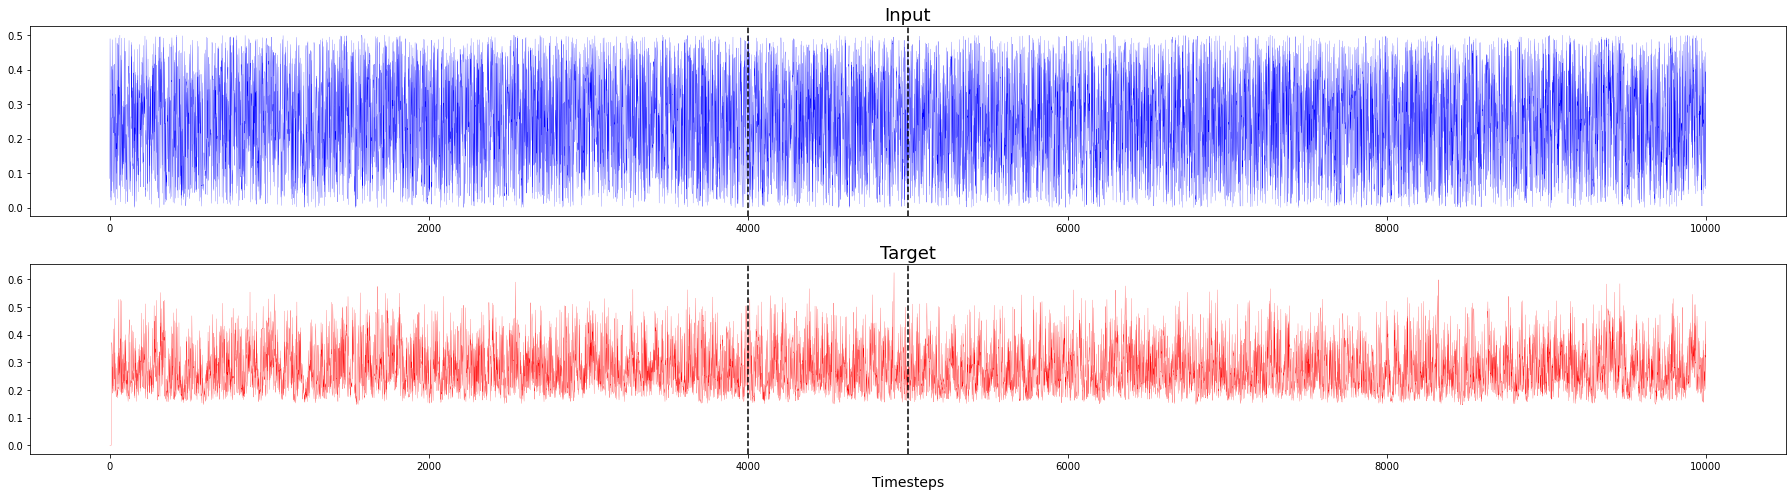

In [162]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
#x_valid = x[4000:5000] #validation
x_test = x[4000:]

y_train = y[:4000]
#y_valid = y[4000:5000]
y_test = y[4000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

## Reservoir

In [163]:
#initialization
Nh = 100
Nx = 1
omega_x = 2 #??
omega_b = 0.2 #??
rho = 0.9
dh = 0.3
dx = 0.5
db = 0.5 # anche il bias deve essere sparse?
l = 0.1 #lambda tickhonoov regularization coefficient

# Initialize weights Wx and Wh
Wx = sparse.rand(Nh, Nx, density=dx)
Wx = Wx.toarray()
Wx = 2 * Wx - 1
Wx = omega_x * Wx

Wh = sparse.rand(Nh, Nh, density=dh)
Wh = Wh.toarray()
Wh = 2 * Wh - 1
Wh = rho * (Wh / np.max(np.abs(np.linalg.eig(Wh)[0])))


# bias 
b = sparse.rand(Nh, Nx, density=db)
b = b.toarray()
b = 2 * b - 1
b = omega_b * b

In [164]:

#Run the reservoir on the input stream
#b = np.ones_like(Wx) 


# Initialize state vector and hidden state history
state = np.zeros((Nh, 1))
H = state.copy()


for t in range(len(x_train)):
    state = np.tanh(Wh.dot(state) + Wx.dot(x_train[t]) + b)
    H = np.hstack((H, state))

print(b.shape)
print(Wx.shape)
print(H.shape)

#discard the washout
washout_size = 200 #va bene tenerlo costante
H = H[:, (washout_size+1):]
print(H.shape)

Y = y_train[washout_size:]
print(Y.shape)

(100, 1)
(100, 1)
(100, 4001)
(100, 3800)
(3800,)


train the readout

In [166]:
Wo = np.dot(np.dot(Y,H.T),np.linalg.inv(np.dot(H,H.T)+l*np.identity(len(np.dot(H,H.T)))))

Text(0.5, 1.0, 'MSE = 0.004462107394202349')

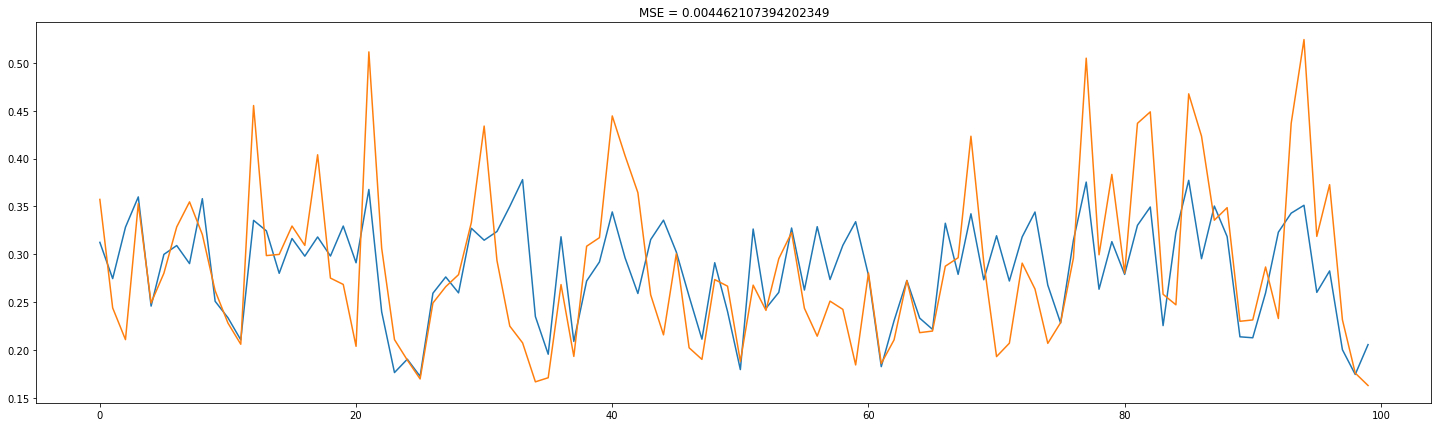

In [167]:
o_tr = np.dot(Wo, H)
err_tr = mean_squared_error(Y, o_tr)

plt.figure(figsize = (25,7))

plt.plot(o_tr[:100])
plt.plot(Y[:100])
plt.title(f'MSE = {err_tr}')


Text(0.5, 1.0, 'MSE = 0.008692503624213671')

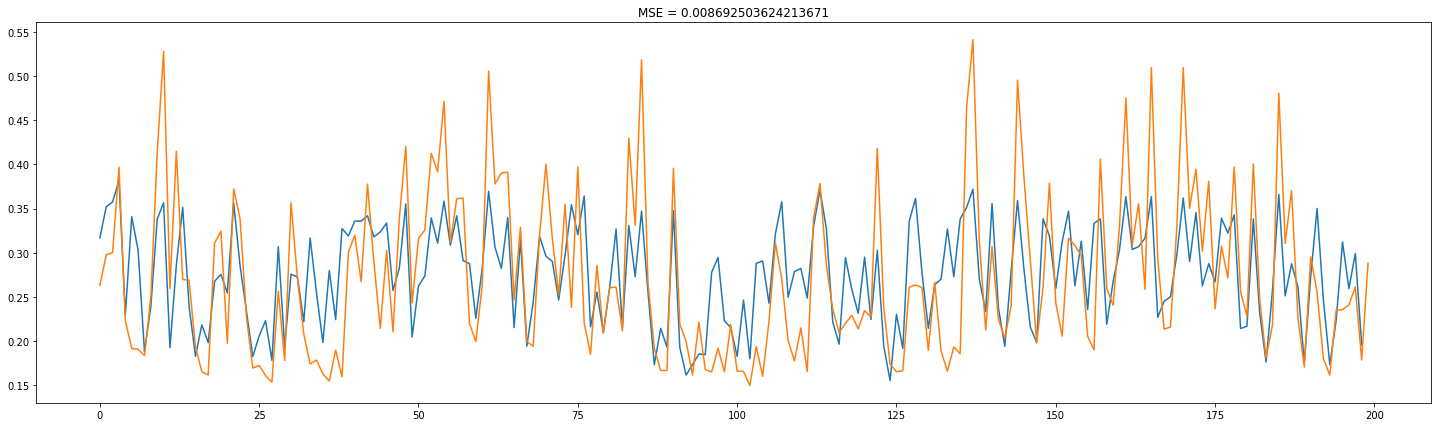

In [168]:
H = state

for t in range(len(x_test)):
    state = np.tanh(Wh.dot(state) + Wx.dot(x_test[t]) + b)
    H = np.hstack((H, state))

o_test = np.dot(Wo, H)
err_test = mean_squared_error(y_test, o_test[:-1])

plt.figure(figsize = (25,7))

plt.plot(o_test[1:200])
plt.plot(y_test[0:200])
plt.title(f'MSE = {err_test}')